# Trabajo Integrador Parte 4

Nombre: Luis Pablo Segovia

Dentro de la carpeta de `data/` vamos a poder encontrar 3 datasets:

- Pokemon (Problema de clasificacion Binaria): La intención es tratar de predecir si basada en la información que tenemos podemos estimar si la carta que estamos viendo es Legendaria o no (Booleano).
- Heart Disease (Problema de clasificacion Binaria): A partir de este dataset vamos a tratar de determinar si una persona basado en ciertos datos tiene asociado una enfermedad cardiaca.
- Challenger USA Space Shuttle O-Ring Data Set (Regresion multivariada): En este dataset encontramos información sobre varios despegues del space shuttle, la intención de este problema es tratar de predecir cuanto será la cantidad de O-Rings que fallan dadas las condiciones de despegue.

> Para la presentación de sus trabajos prácticos **Elijan 1 de los 3 datasets**

# Importar librerías

Importar aquellas librerías que serán utilizadas en el trabajo.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# Cargar datos

Cargar los datos de entrenamiento.

Recordemos que para todos los datasets tenemos el archivo `columns.csv` que contiene el nombre y descripción de cada columna en el mismo orden que van a encontrar los datos.

En los casos de datos con extensión  `*.data` vamos a tener que leerlo utilizando `pd.read_data('myfile.data', sep = ',', header = 0, names = my_cols)`

De esta manera si quisieramos cargar datos por ejemplo de Nasa deberiamos poner algo asi


```python
## Importing python earlier

my_cols = pd.read_csv('./data/nasa_orings/columns.csv').column.values.tolist()

my_data = pd.read_csv('./data/nasa_orings/o-ring-erosion-or-blowby.data',
                       delimiter=',',
                       header=0,
                       names = my_cols
                    )
```

In [2]:
DATASET_PATH = "./data/heart_disease/"

In [3]:
my_cols = pd.read_csv(DATASET_PATH + 'columns.csv').column.values.tolist()

my_data = pd.read_csv(DATASET_PATH + 'processed.cleveland.data',
                       delimiter=',',
                       header=0,
                       names = my_cols
                    )

# Análisis exploratorio básico y preprocesamiento de los datos

Análisis de los datos para conocer los mismos, ver datos faltantes, decidir cómo tratarlos, ver distribuciones, relaciones, etc. Procesar los datos centrándolos, reescalando, codificando, reduciendo dimensiones, etc. según considere necesario.

Vamos a considerar:

- Para escalar datos: `sklearn.preprocessing.StandardScaler()`
- Para completar valores nulos: `sklearn.impute.SimpleImputer()` [Quickguide](https://scikit-learn.org/stable/modules/impute.html)
- Para reduccion de dimensiones (sobre todo para visualizar los datos): PCA o [T-SNE](https://builtin.com/data-science/tsne-python) (Solo para visualización)
- Para codificar variables categóricas: `sklearn.preprocessing.OneHotEncoder()`

In [4]:
# Realizamos un primer approach a la descripción del dataset
my_data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,num
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.410596,0.678808,3.165563,131.645695,246.738411,0.145695,0.986755,149.605960,0.327815,1.035430,1.596026,0.940397
std,9.040163,0.467709,0.953612,17.612202,51.856829,0.353386,0.994916,22.912959,0.470196,1.160723,0.611939,1.229384
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000
50%,55.500000,1.000000,3.000000,130.000000,241.500000,0.000000,0.500000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


- Vemos que tienen diferente escala, lo cual puede ser no bueno para el aprendizaje

In [5]:
# Vemos la información de cada columna del dataset
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    float64
 1   sex       302 non-null    float64
 2   cp        302 non-null    float64
 3   trestbps  302 non-null    float64
 4   chol      302 non-null    float64
 5   fbs       302 non-null    float64
 6   restecg   302 non-null    float64
 7   thalach   302 non-null    float64
 8   exang     302 non-null    float64
 9   oldpeak   302 non-null    float64
 10  slope     302 non-null    float64
 11  ca        302 non-null    object 
 12  thal      302 non-null    object 
 13  num       302 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.2+ KB


- Lo bueno es que no tenemos valores no nulos. Por lo tanto, no será necesario utilizar el imputer.

In [6]:
# Identificamos las columnas en referencia al tipo de dato
numerical_features = ["age", "trestbps", "chol", "thalach", "oldpeak", "thalach"]
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
target = "num"

Una vez separadas las variables por tipo, podemos empezar el analisis. Lo primero es binarizar a la variable target

In [7]:
my_data[target].value_counts()

0    163
1     55
2     36
3     35
4     13
Name: num, dtype: int64

In [8]:
# Enmascaramos los valores: sano=0 y enfermo el resto
y = my_data[target].values
sano_mask = y == 0
enfermo_mask = y > 0
y_class = y.copy()

y_class[sano_mask] = 0
y_class[enfermo_mask] = 1
y_class

array([1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,

In [9]:
pd.get_dummies(my_data[categorical_features])

,sex,cp,fbs,restecg,exang,slope,ca_0.0,ca_1.0,ca_2.0,ca_3.0,ca_?,thal_3.0,thal_6.0,thal_7.0,thal_?
0,1.0,4.0,0.0,2.0,1.0,2.0,0,0,0,1,0,1,0,0,0
1,1.0,4.0,0.0,2.0,1.0,2.0,0,0,1,0,0,0,0,1,0
2,1.0,3.0,0.0,0.0,0.0,3.0,1,0,0,0,0,1,0,0,0
3,0.0,2.0,0.0,2.0,0.0,1.0,1,0,0,0,0,1,0,0,0
4,1.0,2.0,0.0,0.0,0.0,1.0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,1.0,1.0,0.0,0.0,0.0,2.0,1,0,0,0,0,0,0,1,0
298,1.0,4.0,1.0,0.0,0.0,2.0,0,0,1,0,0,0,0,1,0
299,1.0,4.0,0.0,0.0,1.0,2.0,0,1,0,0,0,0,0,1,0
300,0.0,2.0,0.0,2.0,0.0,2.0,0,1,0,0,0,1,0,0,0


In [10]:
# Realizamos un análisis PCA que explique el 90% de la variabilidad
pca = PCA(n_components=0.9).fit(my_data[numerical_features])

pca.n_components_

2

In [11]:
# Transformamos los datos a estos dos componentes
X_transformed = pca.transform(my_data[numerical_features])
X_transformed[:15]

array([[ 41.51972759,  60.43599513],
       [-17.59940165,  30.19207636],
       [  2.12973462, -54.58616297],
       [-43.47434538, -32.47534333],
       [-11.52703173, -39.96766826],
       [ 21.83596944, -13.62517116],
       [106.41609952, -20.39883771],
       [  7.52203752,   4.50457172],
       [-43.32952982,  -6.79174957],
       [-54.08580105,   3.613773  ],
       [ 47.61631832,  -4.88514137],
       [  9.29523476,  10.66383366],
       [ 15.00080685, -34.73139443],
       [-45.80805076, -15.46060048],
       [-77.78444909, -32.13932078]])

<AxesSubplot: >

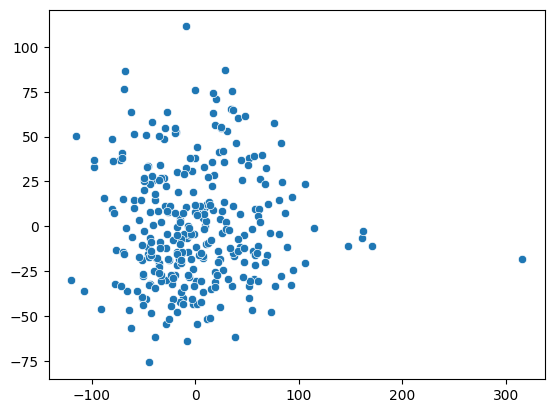

In [12]:
# Graficamos los datos respecto a cada PCi
sns.scatterplot(x=X_transformed[:,0], y=X_transformed[:,1])

# Modelos y evaluación
Probar diferentes modelos para predecir la variable objetivo. Calcular las métricas que considere relevantes. Comentar los resultados. 

In [13]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split

In [14]:
# Revisamos las dimensiones de los datos actuales
y_class.shape

(302,)

### Con PCA

In [15]:
X_transformed.shape

(302, 2)

In [16]:
# Nos fijamos la distribución de los datos de y_class, para saber si están balanceados
sum(y_class == 0) / sum(y_class == 1)

1.1726618705035972

- En el dataset hay un 17% más de datos sobre sanos que de enfermos --> ¿Se puede considerar que está balanceado?

In [17]:
# Definimos un set de train y otro de test
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_class, test_size=0.15, random_state=17)

In [18]:
# Revisamos el balance de sanos-enfermos en ambos sets
print("En train, el balance de sanos-enfermos es: ", sum(y_train == 0) / sum(y_train == 1))
print("En test, el balance de sanos-enfermos es: ", sum(y_test == 0) / sum(y_test == 1))

En train, el balance de sanos-enfermos es:  1.2456140350877194
En test, el balance de sanos-enfermos es:  0.84


- Deberíamos entender si esto es algo problemático en realidad.

In [19]:
# Vamos a probar otro número de seed a ver si se modifica esto
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_class, test_size=0.15, random_state=0)
print("En train, el balance de sanos-enfermos es: ", sum(y_train == 0) / sum(y_train == 1))
print("En test, el balance de sanos-enfermos es: ", sum(y_test == 0) / sum(y_test == 1))

En train, el balance de sanos-enfermos es:  1.1694915254237288
En test, el balance de sanos-enfermos es:  1.1904761904761905


- Nos quedamos con este seed que tiene un porcentaje similar al porcentaje del dataset.

In [20]:
# Realizamos un modelo LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [21]:
# Veamos qué predice el modelo del X_test
y_pred = log_reg.predict(X_test)

In [22]:
log_reg.score(X_test, y_test)

0.6956521739130435

- El score de este modelo es muy bajo. Veamos la matriz de confusión.

In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
confusion_matrix(y_test, y_pred)

array([[22,  3],
       [11, 10]], dtype=int64)

In [25]:
# Vemos el classification report
from sklearn.metrics import classification_report

In [26]:
print("El reporte de clasificación es: \n",classification_report(y_test, y_pred))

El reporte de clasificación es: 
               precision    recall  f1-score   support

           0       0.67      0.88      0.76        25
           1       0.77      0.48      0.59        21

    accuracy                           0.70        46
   macro avg       0.72      0.68      0.67        46
weighted avg       0.71      0.70      0.68        46



### PCA y datos escalados

In [27]:
# Como no tiene buen puntaje, podemos intentar mejorar escalando todos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

In [28]:
# Realizamos los mismos pasos y generamos el modelo de regresión logística
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_class, test_size=0.15, random_state=0)

# Realizamos un modelo LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Veamos qué predice el modelo del X_test
y_pred = log_reg.predict(X_test)
print("La matriz de confusión es: \n",confusion_matrix(y_test, y_pred))
print("El reporte de clasificación es: \n",classification_report(y_test, y_pred))

La matriz de confusión es: 
 [[22  3]
 [11 10]]
El reporte de clasificación es: 
               precision    recall  f1-score   support

           0       0.67      0.88      0.76        25
           1       0.77      0.48      0.59        21

    accuracy                           0.70        46
   macro avg       0.72      0.68      0.67        46
weighted avg       0.71      0.70      0.68        46



- No se ve ningún cambio al escalar los datos

In [29]:
# Probamos con un modelo LogisticRegressionCV
log_regCV = LogisticRegressionCV(cv=5, random_state=0)
log_regCV.fit(X_train, y_train)

LogisticRegressionCV(cv=5, random_state=0)

In [30]:
# Veamos qué predice el modelo del X_test
y_pred = log_reg.predict(X_test)
print("La matriz de confusión es: \n",confusion_matrix(y_test, y_pred))
print("El reporte de clasificación es: \n",classification_report(y_test, y_pred))

La matriz de confusión es: 
 [[22  3]
 [11 10]]
El reporte de clasificación es: 
               precision    recall  f1-score   support

           0       0.67      0.88      0.76        25
           1       0.77      0.48      0.59        21

    accuracy                           0.70        46
   macro avg       0.72      0.68      0.67        46
weighted avg       0.71      0.70      0.68        46



### PCA escalado con 5% de test

In [31]:
# ¿Qué pasa si aumentamos el set de train?
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_class, test_size=0.05, random_state=17)
print("En train, el balance de sanos-enfermos es: ", sum(y_train == 0) / sum(y_train == 1))
print("En test, el balance de sanos-enfermos es: ", sum(y_test == 0) / sum(y_test == 1))

En train, el balance de sanos-enfermos es:  1.183206106870229
En test, el balance de sanos-enfermos es:  1.0


In [32]:
# Realizamos un modelo LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Veamos qué predice el modelo del X_test
y_pred = log_reg.predict(X_test)
print("La matriz de confusión es: \n",confusion_matrix(y_test, y_pred))
print("El reporte de clasificación es: \n",classification_report(y_test, y_pred))

La matriz de confusión es: 
 [[8 0]
 [2 6]]
El reporte de clasificación es: 
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.75      0.86         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16



- Mejora la performance del modelo a aumentar los datos de entrenamiento

### Sin PCA y con categorical features y 15% test

In [42]:
# Apagamos los warnings de convergencia
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [43]:
# Vamos a estudiar el impacto en la performance de la clasificación usando las categorical_features
# Revisamos cuales eran las categorías
categorical_features

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [44]:
# Vemos si hay valores no nulos
my_data[categorical_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   sex      302 non-null    float64
 1   cp       302 non-null    float64
 2   fbs      302 non-null    float64
 3   restecg  302 non-null    float64
 4   exang    302 non-null    float64
 5   slope    302 non-null    float64
 6   ca       302 non-null    object 
 7   thal     302 non-null    object 
dtypes: float64(6), object(2)
memory usage: 19.0+ KB


In [45]:
# La definimos como cats
cats = my_data[categorical_features]

In [46]:
# Realizamos un complete del dataset
complete_dataset = pd.get_dummies(my_data)
complete_dataset

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,...,num,ca_0.0,ca_1.0,ca_2.0,ca_3.0,ca_?,thal_3.0,thal_6.0,thal_7.0,thal_?
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,...,2,0,0,0,1,0,1,0,0,0
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,...,1,0,0,1,0,0,0,0,1,0
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,...,0,1,0,0,0,0,1,0,0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,...,0,1,0,0,0,0,1,0,0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,...,1,1,0,0,0,0,0,0,1,0
298,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,...,2,0,0,1,0,0,0,0,1,0
299,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,...,3,0,1,0,0,0,0,0,1,0
300,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,...,1,0,1,0,0,0,1,0,0,0


In [47]:
# Definimos un X completo
X_complete = complete_dataset.drop('num', axis=1)

In [50]:
# Hacemos el split con este X y con el y_class
X_train, X_test, y_train, y_test = train_test_split(X_complete, y_class, test_size=0.15, random_state=0)
print("En train, el balance de sanos-enfermos es: ", sum(y_train == 0) / sum(y_train == 1))
print("En test, el balance de sanos-enfermos es: ", sum(y_test == 0) / sum(y_test == 1))

# Realizamos un modelo LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Veamos qué predice el modelo del X_test
y_pred = log_reg.predict(X_test)
print("La matriz de confusión es: \n",confusion_matrix(y_test, y_pred))
print("El reporte de clasificación es: \n",classification_report(y_test, y_pred))

En train, el balance de sanos-enfermos es:  1.1694915254237288
En test, el balance de sanos-enfermos es:  1.1904761904761905
La matriz de confusión es: 
 [[20  5]
 [ 2 19]]
El reporte de clasificación es: 
               precision    recall  f1-score   support

           0       0.91      0.80      0.85        25
           1       0.79      0.90      0.84        21

    accuracy                           0.85        46
   macro avg       0.85      0.85      0.85        46
weighted avg       0.86      0.85      0.85        46



In [51]:
# Probamos con un modelo LogisticRegressionCV
log_regCV = LogisticRegressionCV(cv=5, random_state=0)
log_regCV.fit(X_train, y_train)

# Veamos qué predice el modelo del X_test
y_pred = log_reg.predict(X_test)
print("La matriz de confusión es: \n",confusion_matrix(y_test, y_pred))
print("El reporte de clasificación es: \n",classification_report(y_test, y_pred))

La matriz de confusión es: 
 [[20  5]
 [ 2 19]]
El reporte de clasificación es: 
               precision    recall  f1-score   support

           0       0.91      0.80      0.85        25
           1       0.79      0.90      0.84        21

    accuracy                           0.85        46
   macro avg       0.85      0.85      0.85        46
weighted avg       0.86      0.85      0.85        46



- Vemos que el modelo se explica mucho mejor al contar con todas las variables categóricas al mismo % de test.